# IMDB Sentiment Analysis

Sentiment Aanlysis with a CNN TensorFlow model. Based on:
* [This blog post by WILDML](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/)
* [This 2014 paper by Kim](https://arxiv.org/pdf/1408.5882v2.pdf).

In [1]:
%matplotlib inline

# Import packages
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import shuffle
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tflearn.data_utils import VocabularyProcessor

# Define directories
train_pos_dir = 'aclImdb/train/pos/'
train_neg_dir = 'aclImdb/train/neg/'
test_pos_dir = 'aclImdb/test/pos/'
test_neg_dir = 'aclImdb/test/neg/'

# Define dataset sizes
data_set_size = 12500

In [31]:
# Read and process data
stop_words = set(stopwords.words("english"))

with open('aclImdb/imdb.vocab', 'r') as myfile:
    vocab = [x for x in myfile.read().split('\n') if not x in stop_words]

def parse_html(data):
    data = BeautifulSoup(data, 'lxml').get_text() # Remove markup
    data = re.sub("[^a-zA-Z]"," ", data) # Remove all non-alphanumeric characters
    data = ' '.join([x for x in data.lower().split() if not x in stop_words]) # Remove stopwords
    return data

train_pos = []
for file_name in os.listdir(train_pos_dir):
    with open(train_pos_dir + file_name, 'r') as myfile:
        train_pos.append(myfile.read())
        
train_neg = []
for file_name in os.listdir(train_neg_dir):
    with open(train_neg_dir + file_name, 'r') as myfile:
        train_neg.append(myfile.read())

test_pos = []
for file_name in os.listdir(test_pos_dir):
    with open(test_pos_dir + file_name, 'r') as myfile:
        test_pos.append(myfile.read())
        
test_neg = []
for file_name in os.listdir(test_neg_dir):
    with open(test_neg_dir + file_name, 'r') as myfile:
        test_neg.append(myfile.read())                 
    
for i in xrange(data_set_size):
    train_pos[i] = parse_html(train_pos[i])
    train_neg[i] = parse_html(train_neg[i])
    test_pos[i] = parse_html(test_pos[i])
    test_neg[i] = parse_html(test_neg[i])    
    
train_x = np.concatenate([train_pos, train_neg])
train_y = np.concatenate([[[0, 1] for _ in xrange(data_set_size)], [[1, 0] for _ in xrange(data_set_size)]])
test_x = np.concatenate([test_pos, test_neg])
test_y = np.concatenate([[[0, 1] for _ in xrange(data_set_size)], [[1, 0] for _ in xrange(data_set_size)]])
    
print '%i train reviews:' % len(train_x)
print train_x[0][:100]
print '\n%i test reviews:' % len(test_x)
print test_x[0][:100]

25000 train reviews:
anime underrated still hardly dorky kids movie noted still come back years first saw one better movi

25000 test reviews:
sure version film saw entertaining know twins gillian chung charlene choi seeing movie think english


<Container object of 49900 artists>

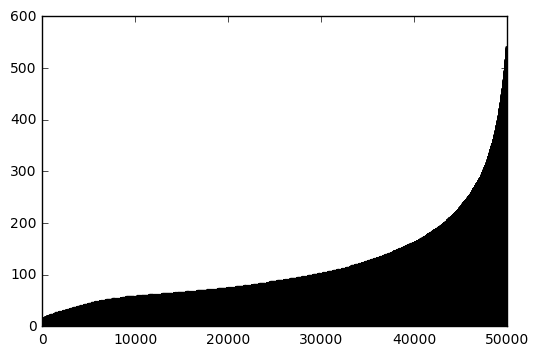

In [3]:
# Graph distribution of review lengths
review_lengths = sorted([len(x.split()) for x in train_x] + [len(x.split()) for x in test_x])[:49900]
plt.bar(range(len(review_lengths)), review_lengths)

In [35]:
# Convert reviews into padded word indexes
num_words = 250 # Based on graph (want to capture most reviews without too much padding)
train_x_vector = np.array(list(VocabularyProcessor(num_words).fit_transform(train_x)))
test_x_vector = np.array(list(VocabularyProcessor(num_words).fit_transform(test_x)))

# Shuffle data
shuffled_i = np.random.permutation(np.arange(data_set_size * 2))
train_x_vector = train_x_vector[shuffled_i]
train_y = train_y[shuffled_i]
test_x_vector = test_x_vector[shuffled_i]
test_y = test_y[shuffled_i]

In [141]:
# Variables
num_steps = 1
batch_size = 64
num_classes = 2
vocab_size = len(vocab) # 89380
word_embedding_size = 128 
patch_size = 5
num_channels = 1
conv_depth = 16
full_nodes = 16
conv_stride = [1, 1, 1, 1]
pool_stride = [1, 2, 2, 1]
padding = 'SAME'

# Graph
graph = tf.Graph()
with graph.as_default():
    # Input layer
    train_x_tf = tf.placeholder(tf.int32, [None, num_words])
    train_y_tf = tf.placeholder(tf.float32, [None, num_classes])
    
    # Embedding layer
    embedding_space = tf.Variable(tf.random_uniform([vocab_size, word_embedding_size])) # 89380 x 128
    train_x_embedded = tf.nn.embedding_lookup(embedding_space, train_x_tf) # None x 250 x 128
    train_x_embedded = tf.expand_dims(train_x_embedded, -1) # None x 250 x 128 x 1

    # Convolution layer 5 x 5 x 1 x 16
    conv_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, conv_depth]))
    conv_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
    
    # Fully connected layer
    full_weights = tf.Variable(tf.truncated_normal([num_words * word_embedding_size * conv_depth, full_nodes]))
    full_biases = tf.Variable(tf.constant(0.1, shape=(full_nodes,)))
    
    # Output layer
    output_weights = tf.Variable(tf.truncated_normal([full_nodes, num_classes]))
    output_biases = tf.Variable(tf.constant(0.1, shape=(num_classes,)))
    
    def model(data):
        conv = tf.nn.relu(tf.nn.conv2d(data, conv_weights, conv_stride, padding) + conv_biases)
        pool = tf.nn.max_pool(conv, pool_stride, pool_stride, padding)
        reshape = tf.reshape(pool, (int(pool.get_shape()[1]), num_words * word_embedding_size * conv_depth))
        full = tf.nn.relu(tf.matmul(reshape, full_weights) + full_biases)
        output = tf.matmul(full, output_weights) + output_biases
        return output
    
    train_output = model(train_x_embedded)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output, train_y_tf))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    train_predictions = tf.nn.softmax(train_output)
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    for i in xrange(num_steps):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_x_vector[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_x_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_predictions], feed_dict) 

InvalidArgumentError: Input to reshape is a tensor with 8192000 values, but the requested shape has 64000000
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](MaxPool, Reshape/shape)]]

Caused by op u'Reshape', defined at:
  File "/home/charlie/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/charlie/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-141-6ccfd14072fb>", line 47, in <module>
    train_output = model(train_x_embedded)
  File "<ipython-input-141-6ccfd14072fb>", line 42, in model
    reshape = tf.reshape(pool, (int(pool.get_shape()[1]), num_words * word_embedding_size * conv_depth))
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1977, in reshape
    name=name)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/charlie/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 8192000 values, but the requested shape has 64000000
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](MaxPool, Reshape/shape)]]
